# NIRCam PSF Fitting

This notebook attempts to fit the NIRCam PSF using multiple Gaussian functions and a window in Fourier space.

The notebook requires numpy, matplotlib, tensorflow, tensorflow_probability, webbpsf, astropy.io fits. A path environmental variable also needs to be set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
!export WEBBPSF_PATH=/data/groups/comp-astro/jades/webbpsf-data 
os.environ["WEBBPSF_PATH"] = "/data/groups/comp-astro/jades/webbpsf-data"
import webbpsf
from astropy.io import fits
tfd = tfp.distributions

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-044 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-045
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


### Load NIRCam PSF

In [2]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
#plt.imshow(psf[0].data)
#webbpsf.display_psf(psf)
data_F200W = psf[0].data

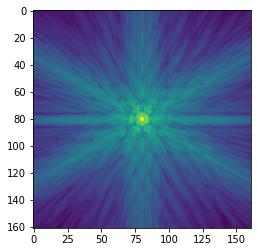

In [58]:
plt.imshow(np.log10(data_F200W))

### Define Loss and Optimizer Functions

In [3]:
# Loss function
loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

### Define MSE TF Functions

In [4]:
#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)
#define mse in log
@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=np.log10(y_true_in),y_pred=np.log10(y_pred_in))

### Define grid positions

In [59]:
def gridxy(nx=161,ny=161):
    xl = np.arange(nx,dtype=np.float32)
    yl = np.arange(ny,dtype=np.float32)
    xl += 0.5
    yl += 0.5
    x,y = np.meshgrid(xl,yl)
    xy = np.dstack((x,y))
    return xy

In [144]:
def gridxyns(nx=161,ny=161):
    xl = np.arange(nx,dtype=np.float32)
    yl = np.arange(ny,dtype=np.float32)
    x,y = np.meshgrid(xl,yl)
    xy = np.dstack((x,y))
    return xy

In [60]:
#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    #sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    #gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return gmvn_a.prob(x)#+gmvn_b.prob(x)

def mvn_one(x, mu, sigma):
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn_a.prob(x)

### Create a single Gaussian model to fit

In [61]:
xy = gridxy()
gg = mvn_one(xy, [0.5*xy.shape[0], 0.5*xy.shape[1]], [5., 6.])

### Perform single Gaussian fitting test

In [62]:
#sig x
sig_x  = tf.Variable(1.0, name='sig_x')                       # 
#sig y
sig_y  = tf.Variable(1.0, name='sig_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    #sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    #gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return gmvn_a.prob(x)#+gmvn_b.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 10000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_one_fit(xy)
        loss = mse(pred, gg)
        #print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x.numpy()} s_y_a:{sig_y.numpy()}")

        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_one_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_x,sig_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_x,sig_y]))

Epoch 0 | Loss 0.0004471043939702213 s_x_a:1.0 s_y_a:1.0
Epoch 1000 | Loss 9.454375685891137e-06 s_x_a:3.5112125873565674 s_y_a:3.5836143493652344
Epoch 2000 | Loss 1.922055616887519e-06 s_x_a:4.327578544616699 s_y_a:4.529084205627441
Epoch 3000 | Loss 4.179765653589129e-07 s_x_a:4.777133941650391 s_y_a:5.140079021453857
Epoch 4000 | Loss 7.783004463135512e-08 s_x_a:4.999119758605957 s_y_a:5.550805568695068
Epoch 5000 | Loss 1.2096625034985209e-08 s_x_a:5.056881427764893 s_y_a:5.805177688598633
Epoch 6000 | Loss 1.315184960937188e-09 s_x_a:5.03212308883667 s_y_a:5.937405109405518
Epoch 7000 | Loss 4.7641248585028606e-11 s_x_a:5.0067925453186035 s_y_a:5.9883646965026855


KeyboardInterrupt: 

### Plot residuals

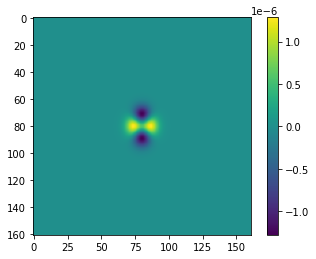

In [63]:
mu = [mu_x_const,mu_y_const]
sigma_a = [sig_x,sig_y]
gmodel = mvn_one(xy,mu,sigma_a)
plt.imshow(gmodel-gg)
plt.colorbar()

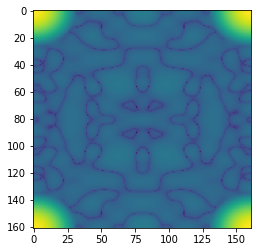

In [66]:
plt.imshow(np.log10(np.absolute(np.fft.fft2(gg))))

### Create two gaussian model to fit

__main__:12: RuntimeWarning: divide by zero encountered in log10


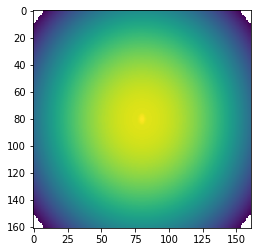

In [67]:
def mvn_two(x, mu, sigma_0, sigma_1):
    #sigma_0 = [sig_0_x,sig_0_y]
    #sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    return gmvn_0.prob(x) + gmvn_1.prob(x)

xy = gridxy()
gg_two = mvn_two(xy, [0.5*xy.shape[0], 0.5*xy.shape[1]], [1., 1.5], [8., 9.])

plt.imshow(np.log10(gg_two))

### Perform two Gaussian fit test

In [68]:
#sig x
sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 10000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(pred, gg_two)
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        #print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x.numpy()} s_y_a:{sig_y.numpy()}")

        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(gg_two,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_0_x,sig_0_y,sig_1_x,sig_1_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_0_x,sig_0_y,sig_1_x,sig_1_y]))

Epoch 0 | Loss 4.8611302190693095e-05 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0
Epoch 1000 | Loss 4.5224362565932097e-07 s_x_a:1.0127887725830078 s_y_a:1.4488390684127808 s_x_b:9.499178886413574 s_y_b:9.621172904968262
Epoch 2000 | Loss 7.593150996854092e-08 s_x_a:1.0000303983688354 s_y_a:1.4987971782684326 s_x_b:8.975089073181152 s_y_b:9.233111381530762
Epoch 3000 | Loss 2.2910612074156234e-08 s_x_a:0.9998705387115479 s_y_a:1.4999035596847534 s_x_b:8.561505317687988 s_y_b:9.001479148864746
Epoch 4000 | Loss 5.5689812761272606e-09 s_x_a:0.9999215006828308 s_y_a:1.5000154972076416 s_x_b:8.284785270690918 s_y_b:8.922348022460938
Epoch 5000 | Loss 1.1968248614380173e-09 s_x_a:0.9999603629112244 s_y_a:1.5000343322753906 s_x_b:8.12876033782959 s_y_b:8.928810119628906
Epoch 6000 | Loss 2.3924792702523234e-10 s_x_a:0.9999815821647644 s_y_a:1.500027060508728 s_x_b:8.053643226623535 s_y_b:8.95653247833252
Epoch 7000 | Loss 4.5014103555729434e-11 s_x_a:0.9999922513961792 s_y_a:1.5000144243240356

KeyboardInterrupt: 

### Plot residuals

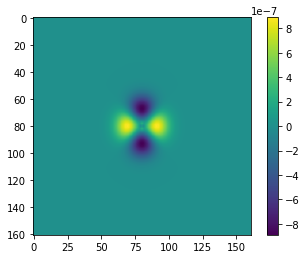

In [69]:
mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
gmodel = mvn_two(xy,mu,sigma_0,sigma_1)
plt.imshow(gmodel-gg_two)
plt.colorbar()

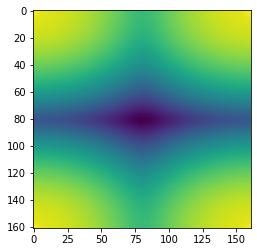

In [71]:
plt.imshow(np.log10(np.absolute(np.fft.fft2(gg_two))))

### Create three gaussian model to fit

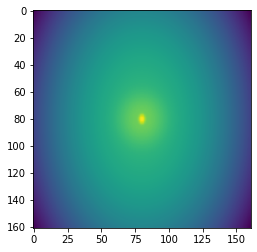

In [72]:
def mvn_three(x, mu, sigma_0, sigma_1, sigma_2):
    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)
    return gmvn_0.prob(x) + gmvn_1.prob(x) + gmvn_2.prob(x)

xy = gridxy()
gg_three = mvn_three(xy, [0.5*xy.shape[0], 0.5*xy.shape[1]], [1., 1.5], [8., 9.], [20., 30.])
plt.imshow(np.log10(gg_three))

### Perform three gaussian test

In [73]:
#sig x
sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')
sig_2_x  = tf.Variable(20.0, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.0, name='sig_2_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return gmvn_0.prob(x)+gmvn_1.prob(x)+gmvn_2.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 10000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
        loss = mse(pred, gg_two)
#        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")


    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
        loss = mse(gg_two,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y]))

Epoch 0 | Loss 4.962383536621928e-05 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0  s_2_x:20.0 s_2_y:20.0
Epoch 1000 | Loss 1.5259715837601107e-06 s_x_a:1.0127904415130615 s_y_a:1.4488321542739868 s_x_b:9.610984802246094 s_y_b:9.810171127319336  s_2_x:20.190961837768555 s_2_y:20.211576461791992
Epoch 2000 | Loss 1.1868407909787493e-06 s_x_a:1.0000228881835938 s_y_a:1.49867582321167 s_x_b:9.18242359161377 s_y_b:9.584223747253418  s_2_x:20.47330093383789 s_2_y:20.510540008544922
Epoch 3000 | Loss 1.1304302915959852e-06 s_x_a:0.9998565316200256 s_y_a:1.4996602535247803 s_x_b:8.833539009094238 s_y_b:9.455551147460938  s_2_x:20.78397560119629 s_2_y:20.830652236938477
Epoch 4000 | Loss 1.0888135193454218e-06 s_x_a:0.9998982548713684 s_y_a:1.4997156858444214 s_x_b:8.583539962768555 s_y_b:9.41006851196289  s_2_x:21.10226058959961 s_2_y:21.15241241455078
Epoch 5000 | Loss 1.055262032423343e-06 s_x_a:0.9999305605888367 s_y_a:1.499733328819275 s_x_b:8.42312240600586 s_y_b:9.4058837890625  s_2_x:21.41

### Plot Residuals

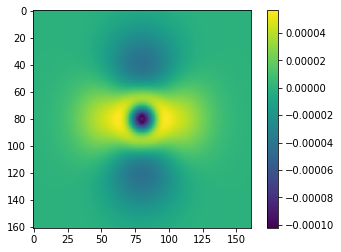

In [74]:
mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
sigma_2 = [sig_2_x,sig_2_y]
gmodel = mvn_three(xy,mu,sigma_0,sigma_1,sigma_2)
plt.imshow(gmodel-gg_three)
plt.colorbar()

### Perform three gaussian fit to PSF

In [75]:
#sig x
a_0 = tf.Variable(1.0, name='a_0')
a_1 = tf.Variable(1.0, name='a_1')
a_2 = tf.Variable(1.0, name='a_2')


sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')
sig_2_x  = tf.Variable(20.0, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.0, name='sig_2_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return tf.math.abs(a_0)*gmvn_0.prob(x)+tf.math.abs(a_1)*gmvn_1.prob(x)+tf.math.abs(a_2)*gmvn_2.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
        loss = mse(pred, data_F200W)
#        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")


    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
        loss = mse(data_F200W,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y]))

Epoch 0 | Loss 4.8670171963749453e-05 a_0:1.0 a_1:1.0 a_2:1.0
Epoch 0 | Loss 4.8670171963749453e-05 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0  s_2_x:20.0 s_2_y:20.0
Epoch 1000 | Loss 5.7405923143960536e-06 a_0:0.672705352306366 a_1:0.4415491223335266 a_2:0.3590575158596039
Epoch 1000 | Loss 5.7405923143960536e-06 s_x_a:0.8442378640174866 s_y_a:0.8568261861801147 s_x_b:10.187299728393555 s_y_b:10.17353343963623  s_2_x:20.199687957763672 s_2_y:20.19658088684082
Epoch 2000 | Loss 5.416784915723838e-06 a_0:0.6774126291275024 a_1:0.35025927424430847 a_2:0.0799488052725792
Epoch 2000 | Loss 5.416784915723838e-06 s_x_a:0.8468939661979675 s_y_a:0.8595331907272339 s_x_b:10.058855056762695 s_y_b:10.023425102233887  s_2_x:20.222251892089844 s_2_y:20.21697425842285
Epoch 3000 | Loss 5.367055564420298e-06 a_0:0.676422119140625 a_1:0.3916280269622803 a_2:1.4741590348421596e-05
Epoch 3000 | Loss 5.367055564420298e-06 s_x_a:0.8463453054428101 s_y_a:0.8589766621589661 s_x_b:9.856491088867188 s_y_b:9.79

### Plot residuals

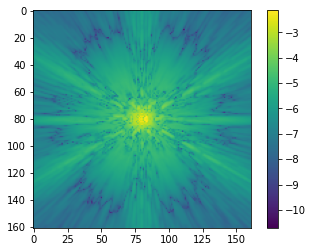

In [76]:
def mvn_three_amp(x, mu, a_0, a_1, a_2, sigma_0, sigma_1, sigma_2):
    gmvn_0 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)
    return  np.fabs(a_0)*gmvn_0.prob(x) +  np.fabs(a_1)*gmvn_1.prob(x) +  np.fabs(a_2)*gmvn_2.prob(x)

mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
sigma_2 = [sig_2_x,sig_2_y]
gmodel = mvn_three_amp(xy,mu,a_0,a_1,a_2,sigma_0,sigma_1,sigma_2)
plt.imshow(np.log10(np.fabs(gmodel-data_F200W)))
plt.colorbar()

### Compute FFT of PSF

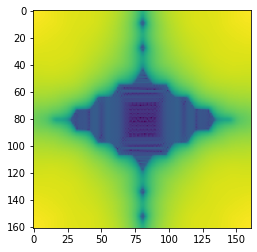

In [77]:
data_F200W_fft = np.absolute(np.fft.fft2(data_F200W))
plt.imshow(np.log10(data_F200W_fft))

### Perform three gaussian fit to PSF with Configuration and Fourier Space MSE loss

In [78]:
#sig x
a_0 = tf.Variable(1.0, name='a_0')
a_1 = tf.Variable(1.0, name='a_1')
a_2 = tf.Variable(1.0, name='a_2')


sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')
sig_2_x  = tf.Variable(20.0, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.0, name='sig_2_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return tf.math.abs(a_0)*gmvn_0.prob(x)+tf.math.abs(a_1)*gmvn_1.prob(x)+tf.math.abs(a_2)*gmvn_2.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
        pred_fft = np.absolute(np.fft.fft2(pred))
        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)
#        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")


    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
        pred_fft = np.absolute(np.fft.fft2(pred))
        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)

        
    #compute gradients
    gradients = g.gradient(loss, [a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y]))

Epoch 0 | Loss 1.2275859445326205 a_0:1.0 a_1:1.0 a_2:1.0
Epoch 0 | Loss 1.2275859445326205 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0  s_2_x:20.0 s_2_y:20.0
Epoch 1000 | Loss 0.11929566777598666 a_0:0.672705352306366 a_1:0.44154924154281616 a_2:0.3590574562549591
Epoch 1000 | Loss 0.11929566777598666 s_x_a:0.8442378640174866 s_y_a:0.8568262457847595 s_x_b:10.187299728393555 s_y_b:10.17353343963623  s_2_x:20.199687957763672 s_2_y:20.19658088684082
Epoch 2000 | Loss 0.11083918831263873 a_0:0.6774125695228577 a_1:0.35025936365127563 a_2:0.07994871586561203
Epoch 2000 | Loss 0.11083918831263873 s_x_a:0.8468939661979675 s_y_a:0.8595330715179443 s_x_b:10.058855056762695 s_y_b:10.023425102233887  s_2_x:20.222251892089844 s_2_y:20.21697425842285
Epoch 3000 | Loss 0.10956033583124736 a_0:0.6764220595359802 a_1:0.3916280269622803 a_2:1.472025724069681e-05
Epoch 3000 | Loss 0.10956033583124736 s_x_a:0.8463452458381653 s_y_a:0.8589766621589661 s_x_b:9.856491088867188 s_y_b:9.791265487670898  s_2_x

### Plot residuals

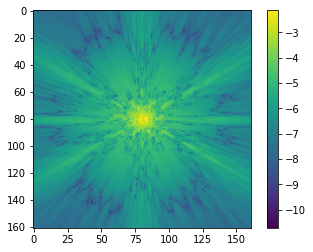

In [79]:
def mvn_three_amp(x, mu, a_0, a_1, a_2, sigma_0, sigma_1, sigma_2):
    gmvn_0 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)
    return  np.fabs(a_0)*gmvn_0.prob(x) +  np.fabs(a_1)*gmvn_1.prob(x) +  np.fabs(a_2)*gmvn_2.prob(x)

mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
sigma_2 = [sig_2_x,sig_2_y]
gmodel = mvn_three_amp(xy,mu,a_0,a_1,a_2,sigma_0,sigma_1,sigma_2)
plt.imshow(np.log10(np.fabs(gmodel-data_F200W)))
plt.colorbar()

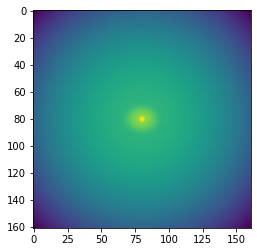

In [88]:
plt.imshow(np.log10(gmodel))

### Test the tukey function

In [106]:
#initialize xy grid
xy = gridxy()
xyns = gridxyns()

t_a = tf.Variable(1.0)

def tukey_trans(fx,a,lam):
#    return 0.5*(1-np.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    return 0.5*(1-tf.math.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    

    
def tukey_calc(x,ta):
    # Def 4.3 of 1901.04365

    
    lam = 82.#mu_x_const
    ta = t_a
    al = (1.0-t_a)*lam
    fx = np.fabs(x)
    y = np.zeros_like(x)
         
    #inner bump
    xs = x[fx<al]
    y[fx<al] = 1.
        
    #transition
    xl = x[(fx>=al)&(fx<=lam)]
    y[(fx>=al)&(fx<=lam)] = tukey_trans(fx[(fx>=al)&(fx<=lam)],ta,lam)
    return y


#tukey filter
#@tf.function
def tukey(x):
    nx = x.shape[0]
    ny = x.shape[0]
    ta = t_a
    nx = x.shape[0]
    ny = x.shape[0]
    ta = t_a
    xx = x#.numpy()
    #return tukey_calc((xx[:,:,0]**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc((xx[:,:,0]**2 + (xx[:,:,1]-ny)**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + (xx[:,:,1]-ny)**2)**0.5,ta)
    x0 = tf.math.sqrt(tf.math.pow(x[:,:,0],2) + tf.math.pow(x[:,:,1],2) ) 
    x1 = tf.math.sqrt(tf.math.pow(x[:,:,0]-nx,2) + tf.math.pow(x[:,:,1],2) ) 
    x2 = tf.math.sqrt(tf.math.pow(x[:,:,0]   ,2) + tf.math.pow(x[:,:,1]-ny,2) ) 
    x3 = tf.math.sqrt(tf.math.pow(x[:,:,0]-nx,2) + tf.math.pow(x[:,:,1]-ny,2) ) 

    return tukey_calc(x0,ta) + tukey_calc(x1,ta) + tukey_calc(x2,ta) + tukey_calc(x3,ta)


__main__:2: RuntimeWarning: divide by zero encountered in log10


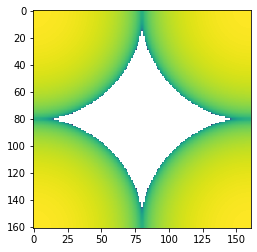

In [107]:
t = tukey(xy)
plt.imshow(np.log10(t))

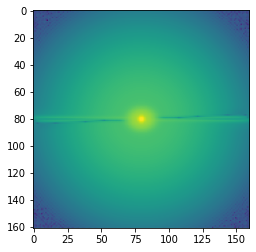

In [108]:

gmodel_new = np.absolute((np.fft.irfft2(np.fft.rfft2(gmodel)*t[:,0:81])))
plt.imshow(np.log10(gmodel_new))
#plt.imshow(np.log10(gmodel-gmodel_new))




### Perform three gaussian fit to PSF with Configuration and Fourier Space MSE loss with Tukey FFT Filter

In [181]:
#initialize xy grid
xy = gridxy()
xyns = gridxyns()
#xy = gridxy()

#sig x
a_0 = tf.Variable(1.0, name='a_0')
a_1 = tf.Variable(1.0, name='a_1')
a_2 = tf.Variable(1.0, name='a_2')


sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')
sig_2_x  = tf.Variable(20.0, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.0, name='sig_2_y')

t_a = tf.Variable(5., name='t_a')


scale = 0.001


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return tf.math.abs(a_0)*gmvn_0.prob(x)+tf.math.abs(a_1)*gmvn_1.prob(x)+tf.math.abs(a_2)*gmvn_2.prob(x)



def tukey_trans(fx,a,lam):
#    return 0.5*(1-np.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    return 0.5*(1-tf.math.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    

    
def tukey_calc(x,ta):
    # Def 4.3 of 1901.04365

    
    lam = mu_x_const
    #ta = t_a
    al = (1.0-t_a)*lam
    #fx = np.fabs(x)
    #y = np.zeros_like(x)
    fx = tf.abs(x)
    y = tf.zeros(x.shape)
    
    #inner bump
    #xs = x[fx<al]
    one_index = tf.math.less(fx,al)
    y = tf.where(one_index,tf.ones(x.shape),tf.zeros(x.shape))
    #return y

    and_index = tf.math.less_equal(fx,lam)&tf.math.greater_equal(fx,al)
    y_trans = tf.where(and_index,tukey_trans(fx,t_a,lam),y)
    y_trans = y
    
    #transition
    #xl = x[(fx>=al)&(fx<=lam)]
    #y[(fx>=al)&(fx<=lam)] = tukey_trans(fx[(fx>=al)&(fx<=lam)],ta,lam)
    return y_trans/tf.math.reduce_max(y_trans)


#tukey filter
@tf.function
def tukey(x):
    nx = x.shape[0]
    ny = x.shape[1]
    ta = t_a
    xx = x#.numpy()
    #return tukey_calc((xx[:,:,0]**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc((xx[:,:,0]**2 + (xx[:,:,1]-ny)**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + (xx[:,:,1]-ny)**2)**0.5,ta)
    x0 = tf.math.sqrt(tf.math.pow(x[:,:,0],2) + tf.math.pow(x[:,:,1],2) ) 
    x1 = tf.math.sqrt(tf.math.pow(x[:,:,0]-nx-1,2) + tf.math.pow(x[:,:,1],2) ) 
    x2 = tf.math.sqrt(tf.math.pow(x[:,:,0]   ,2) + tf.math.pow(x[:,:,1]-ny-1,2) ) 
    x3 = tf.math.sqrt(tf.math.pow(x[:,:,0]-nx-1,2) + tf.math.pow(x[:,:,1]-ny-1,2) ) 

    t_real = tukey_calc(x0,ta) + tukey_calc(x1,ta) + tukey_calc(x2,ta) + tukey_calc(x3,ta)
    
    #return tf.complex(t_real, tf.zeros(x.shape[:1]))
    return t_real


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 10000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
        #pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
        #pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
        tukey_filter = tukey(xyns)
        #pred_fft_comp = tf.complex(pred_fft,
        #pred_fft *= tukey_filter
        #pred = tf.math.abs(tf.signal.ifft2d(tf.complex(pred_fft,tf.zeros_like(pred_fft))))
        pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
        #pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)))
        pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tf.ones_like(pred),tf.math.imag(pred_fft)*tf.ones_like(pred))))

#        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)
        loss = mse(pred, data_F200W) + scale*mse(tf.math.log(tf.abs(pred_fft)), tf.math.log(data_F200W_fft))

#        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} t_a:{t_a.numpy()}")


    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
        #pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
        #pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
        tukey_filter = tukey(xyns)
        #pred_fft_comp = tf.complex(pred_fft,
        #pred_fft *= tukey_filter
        #pred = tf.math.abs(tf.signal.ifft2d(tf.complex(pred_fft,tf.zeros_like(pred_fft))))
        pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
        pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)))
#        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)
        loss = mse(pred, data_F200W) + scale*mse(tf.math.log(tf.abs(pred_fft)), tf.math.log(data_F200W_fft))

        
    #compute gradients
    gradients = g.gradient(loss, [a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y,t_a])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y,t_a]))

Epoch 0 | Loss nan a_0:1.0 a_1:1.0 a_2:1.0
Epoch 0 | Loss nan s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0  s_2_x:20.0 s_2_y:20.0
Epoch 0 | Loss nan t_a:3.0


[W 2022-04-29 12:01:34,674.674 tensorflow] Gradients do not exist for variables ['t_a:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[W 2022-04-29 12:01:34,698.698 tensorflow] Gradients do not exist for variables ['t_a:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[W 2022-04-29 12:01:34,714.714 tensorflow] Gradients do not exist for variables ['t_a:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[W 2022-04-29 12:01:34,727.727 tensorflow] Gradients do not exist for variables ['t_a:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[W 2022-04-29 12:01:34,740.740 tensorflow] Gradients do not exist for variables ['t_a:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[W 2022-04-29 12:01:34,75

KeyboardInterrupt: 

nan


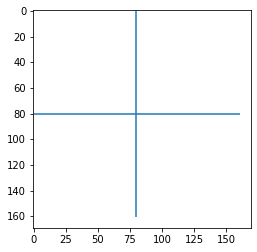

In [182]:
plt.imshow(np.log10(tukey_filter))
print(np.max(tukey_filter))
plt.hlines(80.,0,161)
plt.vlines(80.,0,161)

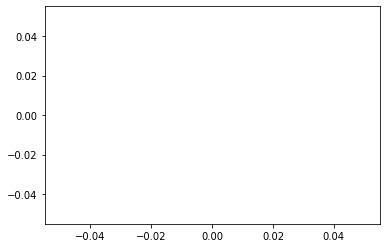

In [183]:
plt.plot(tukey_filter[0,:])

1.7733579


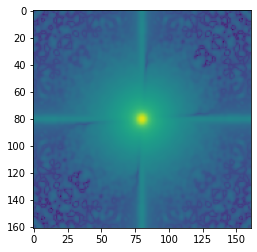

In [157]:
plt.imshow(np.log10(pred),vmin=-8.1,vmax=-0.8)
print(np.sum(pred))

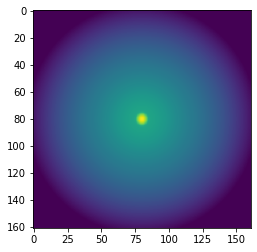

In [153]:
plt.imshow(np.log10(mvn_three_fit(xy)),vmin=-8.1,vmax=-0.8)


-8.093935829214276 -0.8415539081671065


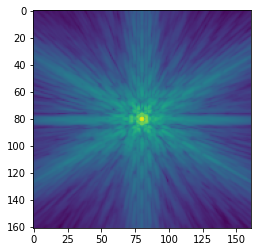

In [154]:
plt.imshow(np.log10(data_F200W),vmin=-8.1,vmax=-0.8)
print(np.min(np.log10(data_F200W)),np.max(np.log10(data_F200W)))

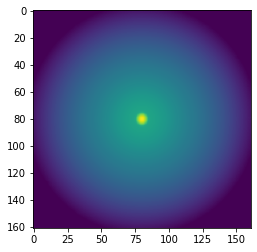

In [159]:
pred = mvn_three_fit(xy)

pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tf.ones_like(pred),tf.math.imag(pred_fft)*tf.ones_like(pred))))
#        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)
#loss = mse(pred, data_F200W) + scale*mse(tf.math.log(tf.abs(pred_fft)), tf.math.log(data_F200W_fft))
plt.imshow(np.log10(pred),vmin=-8.1,vmax=-0.8)

### Test single gaussian fitting

In [ ]:

v = train_model(xy,gg,fit_single_gaussian)

In [ ]:
#x mean
mu_x  = tf.Variable(80.0, name='x_mean')                       # 
#y mean
mu_y  = tf.Variable(80.0, name='y_mean') 
#x sigma
sig_x = tf.Variable(0.75, name='x_sig')
#y sigma
sig_y = tf.Variable(0.75, name='y_sig')

#define model
@tf.function
def mvn_fit(x):
    mu = [mu_x,mu_y]
    sigma = [sig_x,sig_y]
    gmvn = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)



In [ ]:
def mvn_set(x,mu,sigma):
    print(type(mu))
    print(type(sigma))
    gmvn = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn.prob(x)

In [176]:
nx = 161
ny = 161
xl = np.arange(nx,dtype=np.float32)
yl = np.arange(ny,dtype=np.float32)
xl += 0.5
yl += 0.5
x,y = np.meshgrid(xl,yl)
#x += 0.5
#y += 0.5
xy = np.dstack((x,y))
print(xy.shape)
print(xl[80])


(161, 161, 2)
80.5


In [177]:
mu = np.array([0.5*nx,0.5*ny])
Sigma = np.array([10.,8.])
gg = np.reshape(mvn_set(xy,mu,Sigma),(nx,ny))
print(type(gg[0,0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


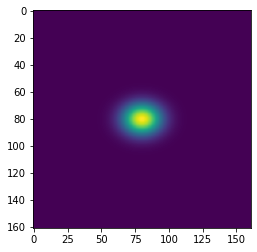

In [178]:
plt.imshow(gg)

In [179]:
print(f" Loss {loss.numpy()}, mu_x: {mu_x.numpy()} mu_y:{mu_y.numpy()} s_x:{sig_x.numpy()} s_y:{sig_y.numpy()}")


NameError: name 'loss' is not defined

In [ ]:
plt.imshow(gg-pred)
plt.colorbar()

In [ ]:
#Try two gaussians

In [180]:
mu = np.array([0.5*nx,0.5*ny])
Sigma_a = np.array([2.,2.5])
Sigma_b = np.array([10.,15.])
mu = np.array([0.5*nx,0.5*ny])
gg = np.reshape(mvn_set(xy,mu,Sigma_a)+mvn_set(xy,mu,Sigma_b),(nx,ny)) 
print(type(gg[0,0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


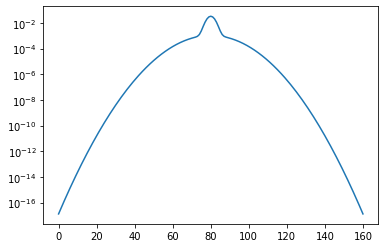

In [181]:
plt.plot(gg[80,:])
plt.yscale('log')

In [182]:
#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return gmvn_a.prob(x)+gmvn_b.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(pred, gg)
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

In [183]:
#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(pred, gg)
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

Epoch 0 | Loss 0.00026576381060294807 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0
Epoch 1000 | Loss 3.153930447297171e-05 s_x_a:1.5910286903381348 s_y_a:1.6185513734817505 s_x_b:10.433030128479004 s_y_b:10.600016593933105
Epoch 2000 | Loss 7.120816007955e-06 s_x_a:1.8599311113357544 s_y_a:1.949873447418213 s_x_b:10.742644309997559 s_y_b:11.149221420288086
Epoch 3000 | Loss 1.7554472151459777e-06 s_x_a:1.9957257509231567 s_y_a:2.1741511821746826 s_x_b:10.897961616516113 s_y_b:11.62136459350586
Epoch 4000 | Loss 4.699901978710841e-07 s_x_a:2.041393280029297 s_y_a:2.328984260559082 s_x_b:10.934714317321777 s_y_b:12.035636901855469


KeyboardInterrupt: 

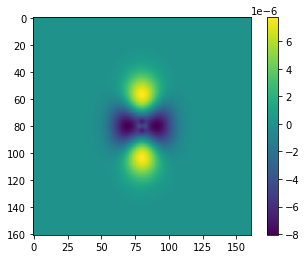

In [21]:
plt.imshow(gg-pred)
plt.colorbar()

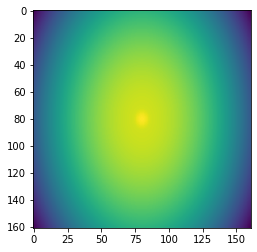

In [22]:
plt.imshow(np.log10(gg))

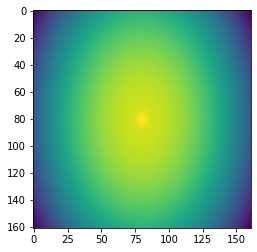

In [23]:
plt.imshow(np.log10(pred))

In [24]:
!python3 -m pip list | grep webbpsf

webbpsf                           1.0.0
You should consider upgrading via the '/cm/local/apps/python37/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!python3 -m pip install webbpsf

In [26]:
!python3 -m pip install astropy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.7 MB 6.6 MB/s eta 0:00:01�█████████████████████▉         | 7.6 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 746 kB 133.1 MB/s eta 0:00:01
You should consider upgrading via the '/cm/local/apps/python37/bin/python3 -m pip install --upgrade pip' command.


In [30]:
import os
!export WEBBPSF_PATH=/data/groups/comp-astro/jades/webbpsf-data 
os.environ["WEBBPSF_PATH"] = "/data/groups/comp-astro/jades/webbpsf-data"

In [32]:
!echo $WEBBPSF_PATH

/data/groups/comp-astro/jades/webbpsf-data


In [33]:
import webbpsf

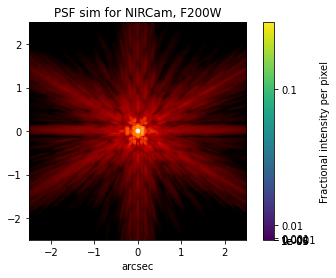

In [34]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
plt.imshow(psf[0].data)
webbpsf.display_psf(psf)

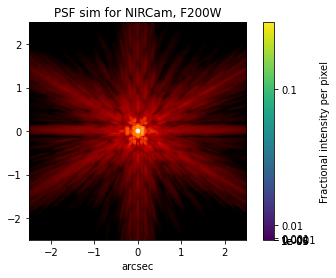

In [35]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
plt.imshow(psf[0].data)
webbpsf.display_psf(psf)

In [36]:
psf_data = psf[0].data

In [37]:
print(psf_data.shape)

(161, 161)


In [39]:
#amp
amp = tf.Variable(0.5, name='amp')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return amp*gmvn_a.prob(x)+(1.-amp)*gmvn_b.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [40]:
#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(psf_data,pred)
        print(f"Epoch {epoch} | Loss {loss.numpy()} amp:{amp.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp,sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp,sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

Epoch 0 | Loss 5.362015144783072e-05 amp:0.5 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0
Epoch 1000 | Loss 5.386983502830844e-06 amp:0.6771688461303711 s_x_a:0.8467398285865784 s_y_a:0.8593774437904358 s_x_b:9.786336898803711 s_y_b:9.770062446594238
Epoch 2000 | Loss 5.35805884283036e-06 amp:0.6767492890357971 s_x_a:0.8465309143066406 s_y_a:0.8591645956039429 s_x_b:9.509998321533203 s_y_b:9.469335556030273
Epoch 3000 | Loss 5.322780907590641e-06 amp:0.6760467886924744 s_x_a:0.846141517162323 s_y_a:0.8587697744369507 s_x_b:9.19122314453125 s_y_b:9.12236213684082
Epoch 4000 | Loss 5.282294750941219e-06 amp:0.675212025642395 s_x_a:0.8456796407699585 s_y_a:0.8583018779754639 s_x_b:8.847630500793457 s_y_b:8.747387886047363
Epoch 5000 | Loss 5.236729975877097e-06 amp:0.674226701259613 s_x_a:0.8451359868049622 s_y_a:0.8577517867088318 s_x_b:8.485675811767578 s_y_b:8.350760459899902
Epoch 6000 | Loss 5.1859001359844115e-06 amp:0.673062264919281 s_x_a:0.8444955945014954 s_y_a:0.8571042418479919 s

-8.093935829214276 -0.8415539081671065


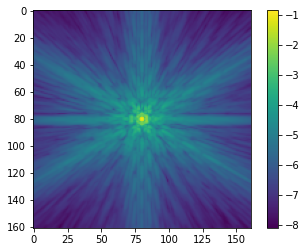

In [41]:
plt.imshow(np.log10(psf_data))
print(np.min(np.log10(psf_data)),np.max(np.log10(psf_data)))
plt.colorbar()

__main__:1: RuntimeWarning: divide by zero encountered in log10


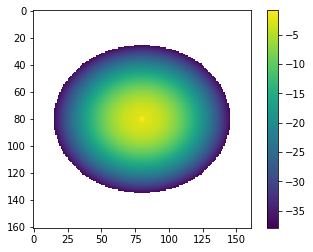

In [42]:
plt.imshow(np.log10(pred))
plt.colorbar()

__main__:2: RuntimeWarning: divide by zero encountered in log10


(-10.0, 0.0)

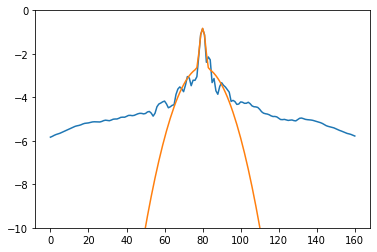

In [43]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:]))
plt.ylim([-10,0])

__main__:2: RuntimeWarning: divide by zero encountered in log10


(-10.0, 0.0)

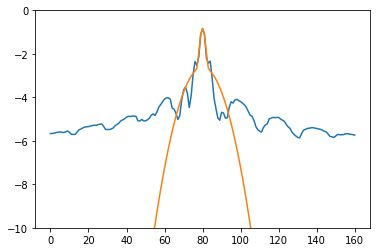

In [44]:
plt.plot(np.log10(psf_data[:,80]))
plt.plot(np.log10(pred[:,80]))
plt.ylim([-10,0])

In [45]:
#amp
amp_a = tf.Variable(0.5, name='amp_a')

#amp
amp_b = tf.Variable(0.25, name='amp_b')

#amp
amp_c = tf.Variable(0.05, name='amp_c')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

#sig x c
sig_x_c  = tf.Variable(20.0, name='sig_x_c')                       # 
#sig y c
sig_y_c  = tf.Variable(20.0, name='sig_y_c')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]
    sigma_c = [sig_x_c,sig_y_c]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)
    gmvn_c = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_c)

    return tf.math.abs(amp_a)*gmvn_a.prob(x)+tf.math.abs(amp_b)*gmvn_b.prob(x)+tf.math.abs(amp_c)*gmvn_c.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=tf.math.log(y_true_in),y_pred=tf.math.log(y_pred_in))

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [46]:
#start training
klam = 1.0e6
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
#        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)

        print(f"Epoch {epoch} | Loss {loss.numpy()} amp_a:{amp_a.numpy()} amp_b:{amp_b.numpy()} amp_c:{amp_c.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()} s_x_c:{sig_x_c.numpy()} s_y_c:{sig_y_c.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
#        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp_a,amp_b,amp_c,sig_x_a,sig_y_a,sig_x_b,sig_y_b,sig_x_c,sig_y_c])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp_a,amp_b,amp_c,sig_x_a,sig_y_a,sig_x_b,sig_y_b,sig_x_c,sig_y_c]))

Epoch 0 | Loss 1513.8546142578125 amp_a:0.5 amp_b:0.25 amp_c:0.05000000074505806 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0 s_x_c:20.0 s_y_c:20.0
Epoch 1000 | Loss 692.5671997070312 amp_a:0.6894079446792603 amp_b:0.00017963710706681013 amp_c:0.26414695382118225 s_x_a:0.8559169173240662 s_y_a:0.8686662316322327 s_x_b:9.811483383178711 s_y_b:9.82666015625 s_x_c:20.798891067504883 s_y_c:20.72877311706543
Epoch 2000 | Loss 591.0145263671875 amp_a:0.6908637881278992 amp_b:7.801499305060133e-05 amp_c:0.20947836339473724 s_x_a:0.8573092818260193 s_y_a:0.8700233101844788 s_x_b:9.807819366455078 s_y_b:9.823643684387207 s_x_c:21.553375244140625 s_y_c:21.383161544799805
Epoch 3000 | Loss 506.494384765625 amp_a:0.6907860636711121 amp_b:-0.014909081161022186 amp_c:0.15912774205207825 s_x_a:0.8572038412094116 s_y_a:0.8699225783348083 s_x_b:9.454042434692383 s_y_b:9.51197624206543 s_x_c:22.33671760559082 s_y_c:22.083282470703125
Epoch 4000 | Loss 437.8367614746094 amp_a:0.6884675621986389 amp_b:-0.038

(-10.0, 0.0)

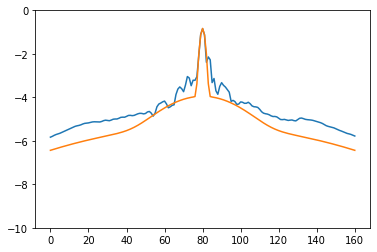

In [47]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:].numpy()))
plt.ylim([-10,0])

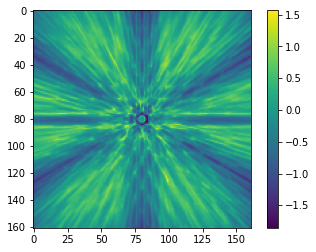

In [50]:
plt.imshow(np.log10(pred)-np.log10(psf_data))
plt.colorbar()

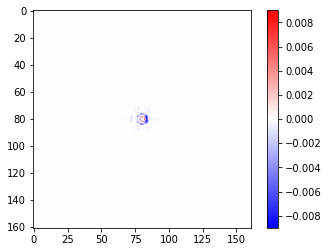

In [55]:
plt.imshow(pred-psf_data,vmin=-0.009,vmax=0.009,cmap='bwr')
plt.colorbar()

In [52]:
def tukey(x,lam,a):
    # Def 4.3 of 1901.04365

    def tukey_trans(fx,a,lam):
        return 0.5*(1-np.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    
    al = (1.0-a)*lam
    fx = np.fabs(x)
    if(isinstance(x,float)):
        y = 0.0
        if(fx<al):
            y = 1.0
        elif(fx<=lam):
            y = tukey_trans(fx,a,lam)
    else:
        y = np.zeros_like(x)
         
        #inner bump
        xs = x[fx<al]
        y[fx<al] = 1.
        
        #transition
        xl = x[(fx>=al)&(fx<=lam)]
        y[(fx>=al)&(fx<=lam)] = tukey_trans(fx[(fx>=al)&(fx<=lam)],a,lam)
    return y

In [45]:
#amp
amp_a = tf.Variable(0.5, name='amp_a')

#amp
amp_b = tf.Variable(0.25, name='amp_b')

#amp
amp_c = tf.Variable(0.05, name='amp_c')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

#sig x c
sig_x_c  = tf.Variable(20.0, name='sig_x_c')                       # 
#sig y c
sig_y_c  = tf.Variable(20.0, name='sig_y_c')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]
    sigma_c = [sig_x_c,sig_y_c]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)
    gmvn_c = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_c)

    return tf.math.abs(amp_a)*gmvn_a.prob(x)+tf.math.abs(amp_b)*gmvn_b.prob(x)+tf.math.abs(amp_c)*gmvn_c.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=tf.math.log(y_true_in),y_pred=tf.math.log(y_pred_in))

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
#apply tukey bump function to 

In [159]:
#define model
@tf.function
def model_function(x):
    
    #initial 3 gaussian approximation
    gapp = mvn_three_fit(x)
    
    #take fourier transform
    gapp_fft = tf.signal.fft2d(gapp)
    
    return gcomp
    
    

In [160]:
#start training
klam = 1.0e6
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = model_function(xy)
        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
#        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)

        print(f"Epoch {epoch} | Loss {loss.numpy()} amp_a:{amp_a.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = model_function(xy)
        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
#        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp_a,sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp_a,sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

Epoch 0 | Loss 5.5345164582831785e-05 amp_a:0.5 s_x_a:1.0 s_y_a:1.0 s_x_b:20.0 s_y_b:20.0
Epoch 1000 | Loss 5.864741979166865e-06 amp_a:0.6843382120132446 s_x_a:0.8507255911827087 s_y_a:0.8634271621704102 s_x_b:19.93864631652832 s_y_b:19.935131072998047
Epoch 2000 | Loss 5.863028036401374e-06 amp_a:0.6845124363899231 s_x_a:0.8508569002151489 s_y_a:0.8635590672492981 s_x_b:19.85904884338379 s_y_b:19.850494384765625
Epoch 3000 | Loss 5.861129011464072e-06 amp_a:0.6844881176948547 s_x_a:0.850843071937561 s_y_a:0.8635450005531311 s_x_b:19.771150588989258 s_y_b:19.757080078125
Epoch 4000 | Loss 5.859134944330435e-06 amp_a:0.68446284532547 s_x_a:0.8508287668228149 s_y_a:0.8635305762290955 s_x_b:19.67995262145996 s_y_b:19.660093307495117
Epoch 5000 | Loss 5.857070846104762e-06 amp_a:0.6844370365142822 s_x_a:0.8508142232894897 s_y_a:0.8635156154632568 s_x_b:19.586524963378906 s_y_b:19.560911178588867
Epoch 6000 | Loss 5.854949449712876e-06 amp_a:0.6844106316566467 s_x_a:0.8507993817329407 s_y_

KeyboardInterrupt: 

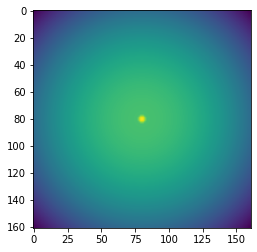

In [162]:
plt.imshow(np.log10(pred))

(-10.0, 0.0)

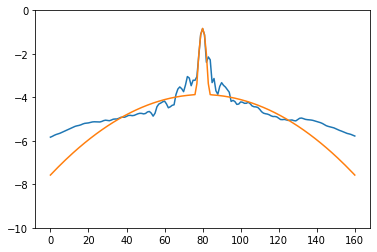

In [163]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:].numpy()))
plt.ylim([-10,0])

In [165]:
pred_fft = tf.signal.fft2d(tf.cast(pred,dtype=tf.complex64))

In [174]:
print((np.absolute(pred_fft.numpy()).shape))

(161, 161)


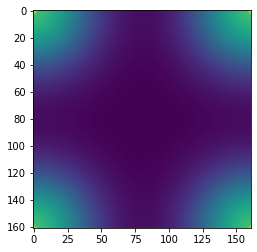

In [166]:
plt.imshow(tf.abs(pred_fft))

In [167]:
pred_ifft = tf.signal.ifft2d(pred_fft)

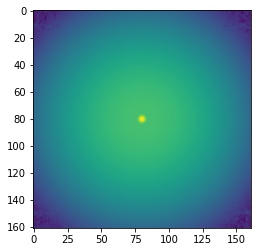

In [169]:
plt.imshow(np.log10(tf.abs(pred_ifft)))